In [1]:
import pandas as pd
import gmaps
import getpass
import metnoRequests as metno
from encrypt import decryptCredentials,decryptString
import LangtjernWeather as lw
import os
import shutil
import matplotlib
import pickle
from bs4 import BeautifulSoup
from bs4 import SoupStrainer
import requests
import re
from urllib.parse import urljoin
from subprocess import Popen, PIPE, CalledProcessError
import platform
import time
from IPython.display import clear_output, display
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import math
import statsmodels.api as sm
from patsy import dmatrices
import fileinput
import instantiationFimex as fimex
import datetime

def login():
    username = input("Username: [JLG] ") #default username JLG
    if not username :
        username = "JLG"
    password = getpass.getpass('Password: ')
    return username, password

def create_dir(dir_name) :
    if not os.path.exists(dir_name) :
        os.makedirs(dir_name)
    else :
        shutil.rmtree(dir_name)
        os.makedirs(dir_name)
        
options = {'stdout': PIPE, 'stderr': PIPE, 'bufsize' : 1, 'universal_newlines' : True, 'shell' : False}
if (platform.system() == 'Windows'):
    options['shell'] = True
    #Packages required to generate ssh keys in windows
    from cryptography.hazmat.primitives import serialization as crypto_serialization
    from cryptography.hazmat.primitives.asymmetric import rsa
    from cryptography.hazmat.backends import default_backend as crypto_default_backend

def callPopen(cmd,verbose=True,overwrite=False):
    with Popen(cmd.split(),**options) as p:
        if verbose and not overwrite:
            for line in p.stdout:
                print(line, end='')
        if verbose and overwrite:
            for line in p.stdout:
                clear_output(wait=True)
                display(line)
        for line in p.stderr:
            print(line, end='')
        if p.returncode != (0 or None):
            raise CalledProcessError(p.returncode, p.args)


def isInstance(name):
    instanceExists=False
    ip=''
    with Popen('gcloud compute instances list'.split(),**options) as p:
        for line in p.stdout:
            if re.match('^{}'.format(name), line):
                instanceExists=True
                ip = line.strip().split()
                ip = ip[4]
        for line in p.stderr:
            print(line, end='')
        if p.returncode != (0 or None):
            raise CalledProcessError(p.returncode, p.args)
        return(instanceExists,ip)
    
            
def text_prepender(filename, text):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(text.rstrip('\r\n') + content)

def replace(file,pattern,replace):
    fileinput.close()
    for line in fileinput.input(file, inplace=True):
        print( re.sub(pattern,
                      replace,
                      line.rstrip()
                      ) 
             )
        
if (platform.system() == 'Windows'):
    def generateSSHKey(username,savePath):
        key = rsa.generate_private_key(
            backend=crypto_default_backend(),
            public_exponent=65537,
            key_size=2048
            )
        private_key = key.private_bytes(
            crypto_serialization.Encoding.PEM,
            crypto_serialization.PrivateFormat.TraditionalOpenSSL,
            crypto_serialization.NoEncryption()
            )
        public_key = key.public_key().public_bytes(
            crypto_serialization.Encoding.OpenSSH,
            crypto_serialization.PublicFormat.OpenSSH
            )
        public_file = os.path.join(savePath,username + '.pub')
        private_file = os.path.join(savePath,username)
        text_file = open(public_file, "w")
        text_file.write(public_key.decode('utf-8') + ' ' + username)
        text_file.close()
        text_file = open(private_file, "w")
        text_file.write(private_key.decode('utf-8'))
        text_file.close()
        print('Successfully created key pair')
            
if (platform.system() == 'Linux'):
    def generateSSHKey(username,savePath):
        p = Popen("echo 'yes' | ssh-keygen -t rsa -f {0}/{1} -C {1} -N '' ".format(savePath,username),
              stdout=PIPE,
              shell=True,
              stderr=PIPE
               )
        print(p.communicate())   

# Water temperature

In [2]:
file = 'Temperature stations in rivers.xlsx'
xl = pd.ExcelFile(file)
print(xl.sheet_names)

# Load a sheet into a DataFrame by name: df1
df = xl.parse('Sheet 1')
df.dropna(inplace=True)
df.index = df.STATION_ID
df.drop(columns = ['STATION_ID'],inplace=True)
# df = df[df.COUNT_TEMPERATURE > 100]
display(df)

['Sheet 1']


,COUNT_TEMPERATURE,GEOM_REF_ID,LONGITUDE,LATITUDE,STATION_CODE,STATION_NAME,PROJECT_NAME
STATION_ID,,,,,,,
10101,16,9938.0,7.763336,61.048130,Lærdal 9,Sjurhaugfoss oppstrøms doserer,GYROMET
10095,15,9932.0,7.523421,61.060248,Lærdal 3,Voll fisk,GYROMET
10105,22,9942.0,7.669039,61.057299,Lærdal 13,Bjørkum,GYROMET
10107,17,9944.0,7.637928,61.049258,Lærdal 15,Kraftgata,GYROMET
10109,7,9946.0,7.661348,61.027502,Lærdal 17,Nivla B,GYROMET
10098,10,9935.0,7.622513,61.044280,Lærdal 6,Nivla fisk,GYROMET
6342,25,4859.0,11.498830,59.967660,AKEEFLU,"Utløp Floen, Haratun",VAS_SKU
6343,104,4860.0,10.782930,59.754750,AKEEFÅL,Fåleslora,VAS_FAA
6360,308,4877.0,10.933410,60.011290,AKEEN5;Nitelva1,"Slattum, Nitelva;Slattum, Nitelva2",VAS_AAN;NitelvaStasjoner


In [3]:
file = 'Nedbørfeltinfo referanseelver_oppdatert_HIN.xlsx'
xl = pd.ExcelFile(file)

# Load a sheet into a DataFrame by name: df1
df_ref = xl.parse('Sheet1')
#Finding aquamonitor station id
refList=pd.DataFrame()
for row  in df_ref.itertuples():
#     display(df[[row.Rapportnavn.split(' ')[1] in x for x in df.STATION_NAME]])
    if df[[row.Kode in x for x in df.STATION_CODE]].empty:
        display(row.Rapportnavn)
    refList = refList.append(df[[row.Kode in x for x in df.STATION_CODE]])
refList.drop_duplicates(inplace=True)
display(refList)

df = df[df.COUNT_TEMPERATURE > 100]

,COUNT_TEMPERATURE,GEOM_REF_ID,LONGITUDE,LATITUDE,STATION_CODE,STATION_NAME,PROJECT_NAME
STATION_ID,,,,,,,
69523,11,62356.0,24.898530,70.174699,F_223-103_Sta,Stabburselva,Overvåkning i referanseelver
69524,9,62357.0,25.672275,70.359922,F_225-88_Bor,Børselvvassdraget,Overvåkning i referanseelver
69525,11,62358.0,28.068469,70.273776,F_234-229_Más,Máskejohka/Masjok,Overvåkning i referanseelver
69526,11,62360.0,30.310864,70.183969,F_239-35_Ska,"Skallelva, nedre",Overvåkning i referanseelver
69527,11,62361.0,30.513587,70.242022,F_239-37_Kom,"Komagelva, nedre",Overvåkning i referanseelver
69528,8,62362.0,30.447641,70.507876,F_238-48_San,Sandfjordelva - Dávatjohka bekkefelt,Overvåkning i referanseelver
69529,10,62363.0,23.738173,69.211938,F_212-1729_Láh,Láhpojohka,Overvåkning i referanseelver
69530,11,62364.0,29.718984,69.400171,F_246-15_Sam,Sametielva,Overvåkning i referanseelver
69540,11,62374.0,9.594602,62.441250,M_109-199_Dri,"Driva, Svånnå - Rundhaugen",Overvåkning i referanseelver


In [4]:
#Setting up credentials for database access. These should have been previously encrypted
token = b'gAAAAABayyyn8ZnEstm8ZQqClUYQ-IqFFuMO4QTbmFJADHWBAcirh52s5stDwSwtVK7qVm5tzdTNFxTQjuRF28b1t2rosFSl_nnTowWrD4itOjkzF7s6Kg_qa1Adqpj59OAfBapgkToUQUHvEFY1Njc4he36AC76gmb8t0CJCq4ze2pDHWIlGdDacZxQ1jq14uLVxrFfCTSxDPX8Mx9W1av723etkOdWvw=='
key = getpass.getpass('Password: ')
credentials = decryptCredentials(token,key)
#credentials['host'] = basinGenerator.ip #This is because we don't have a static address for the host. A static address is provided if one uses catchment.niva.no

#Setting up credentials for google maps api access
apiToken = b'gAAAAABaXyLsGnF3ms4sC3ZhoLCwWAx9q0tydWl8XKEwOy8CO0W6Eqc8J4om8HNDlNR9nExYCmSrelp8W5R-PLtcce1I2UgW3YnlXXqWvrMN-outYwXhZoc59djfF752mzOPqXBHgpNC'
apiKey = decryptString(apiToken,key)
gmaps.configure(api_key=apiKey)

metnoToken = b'gAAAAABaYEqld0O48m09jEyMUBFTdBmZA2BVey2r7FKbo_7zrJPOa1aEGcpW0WmnhGVJHYUPm32f8ttaiboXxAF-Q9hDat3lhsa4ELzrT6J_e402kRDmWi6k0kpldOC2LTBNM9vNLLF4'
metnoKey = decryptString(metnoToken, key)
metno.init(metnoKey,'https://frost.met.no')

Password:  ·······


## Station locations

In [5]:
def getMarkerLayer():
    info_box_template = """
    <dl>
    <dt>Met station</dt><dd>{}</dd>
    <dt>id</dt><dd>{}</dd>
    </dl>
    """    
    station_locations = refList[['LATITUDE','LONGITUDE']].values
    station_names = refList['STATION_NAME']
    station_info = [info_box_template.format(x,y) for x, y in zip(refList['STATION_NAME'], refList.index)]
    return gmaps.marker_layer(station_locations, info_box_content=station_info)

fig = gmaps.figure()
fig.add_layer(getMarkerLayer())
fig

Figure(layout=FigureLayout(height='420px'))

## Downloading data for reference rivers

In [6]:
download = False
if download:    
    now = pd.to_datetime('today').strftime('%Y-%m-%d')
    datesToGet = '1900-01-01/{}'.format(now)
    start = datesToGet.split('/')

    finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
    start = pd.datetime.strptime(start[0],'%Y-%m-%d')

    username,password = login()

    #Folder where the downloaded data will be saved
    root = "./DownloadedData/"
    create_dir(root)
    referenceData = {}
    for idx,row in refList.iterrows():
        referenceData[idx] = lw.getData(username,password,root,
                         pd.datetime.strftime(start,'%Y/%m/%d'),
                         pd.datetime.strftime(finish,'%Y/%m/%d'),
                         idx,
                         'Water'
                         ) 

    with open('referenceData.pickle', 'wb') as handle:
        pickle.dump(referenceData, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('referenceData.pickle', 'rb') as handle:
        referenceData = pickle.load(handle)
        
#Getting rid of empty frames
# for key in data.copy():
#     if data[key].empty :
#         del data[key]

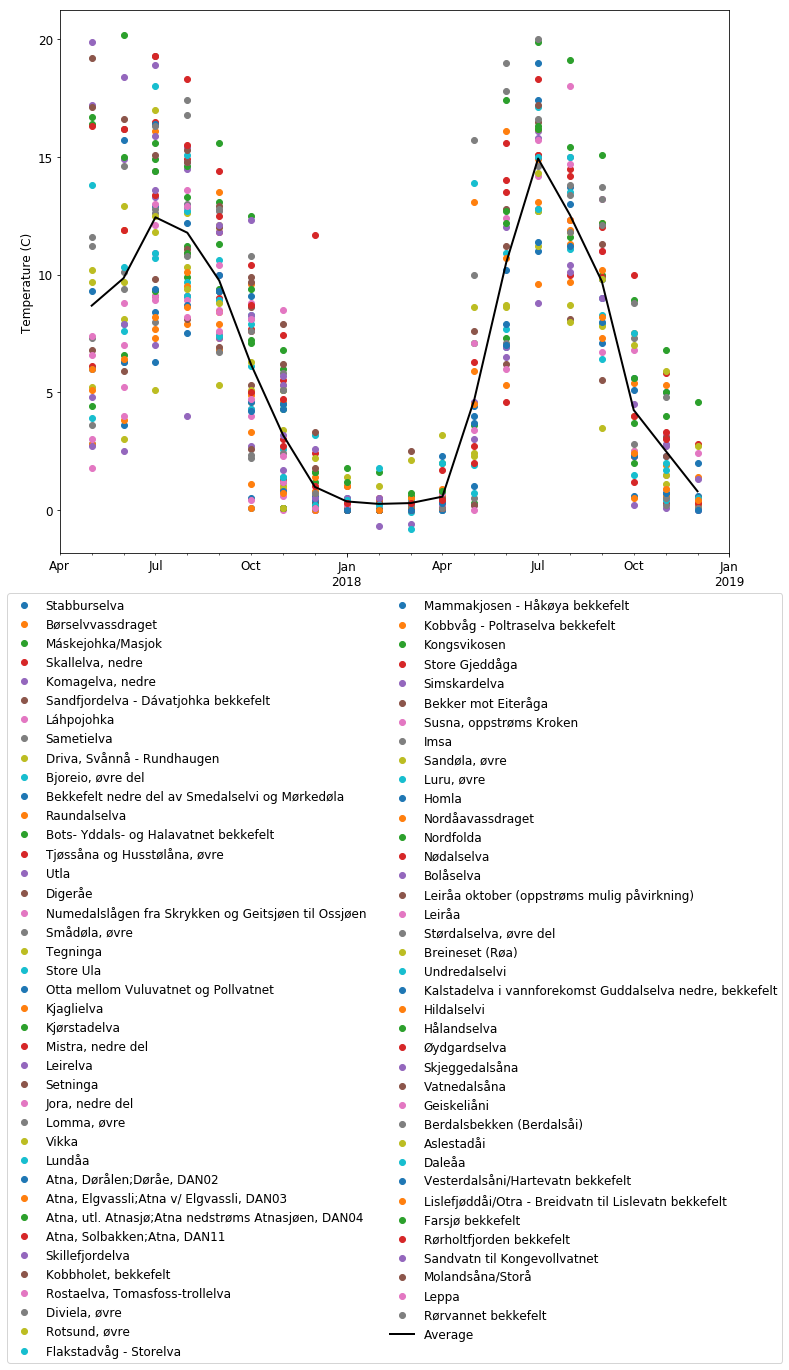

In [11]:
import matplotlib 
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

referenceFrame = pd.DataFrame()
for key in referenceData:
    if not (referenceData[key].empty):
        currentFrame = referenceData[key].loc[~referenceData[key].index.duplicated(keep='first')]
        currentFrame.name = refList.loc[key,'STATION_NAME']
        currentFrame = currentFrame.to_frame()
    else:
        currentFrame = pd.DataFrame(columns=[refList.loc[key,'STATION_NAME']])
    
    referenceFrame = pd.concat([referenceFrame,currentFrame],axis=1)
ax = referenceFrame.resample('m').mean().plot(figsize=(12,20),linestyle='None', marker = 'o' ) 


dummy = referenceFrame.resample('m').mean()
dummy = dummy.mean(axis=1).to_frame()
dummy.columns = ['Average']
dummy.plot(ax=ax,color='k',linewidth=2)

ax.legend(loc = 'lower center', fancybox=True,ncol = 2,bbox_to_anchor=(0.5, -1.5))
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height*0.6 , box.width, box.height*.5])
ax.set_xlim([datetime.date(2017,4,1), datetime.date(2019, 1, 1)])
ax.set_ylabel('Temperature (C)')
plt.savefig('referanse.png') 

referenceFrame.resample('m').mean().to_csv('allData.csv')

## Downloading data 

In [9]:
download = False
if download:    
    now = pd.to_datetime('today').strftime('%Y-%m-%d')
    datesToGet = '1900-01-01/{}'.format(now)
    start = datesToGet.split('/')

    finish = pd.datetime.strptime(start[1],'%Y-%m-%d')
    start = pd.datetime.strptime(start[0],'%Y-%m-%d')

    username,password = login()

    #Folder where the downloaded data will be saved
    root = "./DownloadedData/"
    create_dir(root)
    data = {}
    for idx,row in df.iterrows():
        data[idx] = lw.getData(username,password,root,
                         pd.datetime.strftime(start,'%Y/%m/%d'),
                         pd.datetime.strftime(finish,'%Y/%m/%d'),
                         idx,
                         'Water'
                         ) 

    with open('data.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('data.pickle', 'rb') as handle:
        data = pickle.load(handle)
        
#Getting rid of empty frames
# for key in data.copy():
#     if data[key].empty :
#         del data[key]

In [10]:
singleFrame = pd.DataFrame()
not_include=['Fåleslora','Urdevann innløp, loggestasjon','Kaldvellelva, loggestasjon',
            'Årungselva utløp','Bjørnlidammen','Kaldvellelva REF, loggestasjon','Fjelldalselva,loggestasjon',
            'Steindalsbekken, loggestasjon','Mosseelva;Mosseelva;Mosseelva','ST1(NAVN!)',
             'Frøyset', 'Akerselva, ved Arkitekthøyskolen','Akerselva, ved Brenneriveien','Utløp Grunnstollen - Nordgruvefeltet',
             'Seterdam 2','Borg havn - midtstrøms','Borg havn - midtstrøms 2','Borg havn - brygge 2','Borg havn - brygge','Akerselva, ved Grünerhagen park',
             'Tangedalselva','Akerselva-kulverten, utløp','Akerselva, neds. Ankerbrua'
            ]
for key in data:
    name = df.loc[key,'STATION_NAME']
    if not (data[key].empty)  and not np.any([x == name for x in not_include]):
        display(name)
        currentFrame = data[key].loc[~data[key].index.duplicated(keep='first')]
        currentFrame.name = name
        currentFrame = currentFrame.to_frame()
        currentFrame[currentFrame < 0.] = np.nan
        currentFrame[currentFrame > 50. ] = np.nan 
#     else:
#         currentFrame = pd.DataFrame(columns=[name])
    
        singleFrame = pd.concat([singleFrame,currentFrame],axis=1)

idx = np.logical_not(np.in1d(df.STATION_NAME,not_include))
df = df[idx]

'Slattum, Nitelva;Slattum, Nitelva2'

'Horpestadvatnet utløp'

'Roslandsåna, utløp Horpestadv.'

'Lalandsbekken,'

'Gjersjøelva'

'Roslandsåna, utl. Frøylandsv.'

'Hinnalandsbekken'

'Dalsbekken. (Setrebekken.)'

'Kantorbekken'

'Tussebekken'

'Orrevatn utløp'

'Frogner, Leira'

'Greverudbekken'

'Lindalsbekken, utløp Frøylandsv.'

'Kvernlandsbekken,utl Frøylandsv.'

'Utløp av Langtjern'

'Hjerkinn'

'Ynnesdal'

'Raubekken'

'NIVA FSF'

'Adventelva, Gamle nordlysstasjonen Svalbard'

'Klodeborg, Skrubbedalsveien'

'Drammenselva sensor'

'Seterdam 1'

'NIVA FSF2'

'Alna;Alna;Alna, RID stasjon;Alna;Alna v/Kværnerbyen;Alna'

'Baterød vannverk'

'Budalselva'

'Innløpet LAE03 - Langtjern'

'Målselva - loggestasjon'

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4a0840b828>,
      dtype=object)

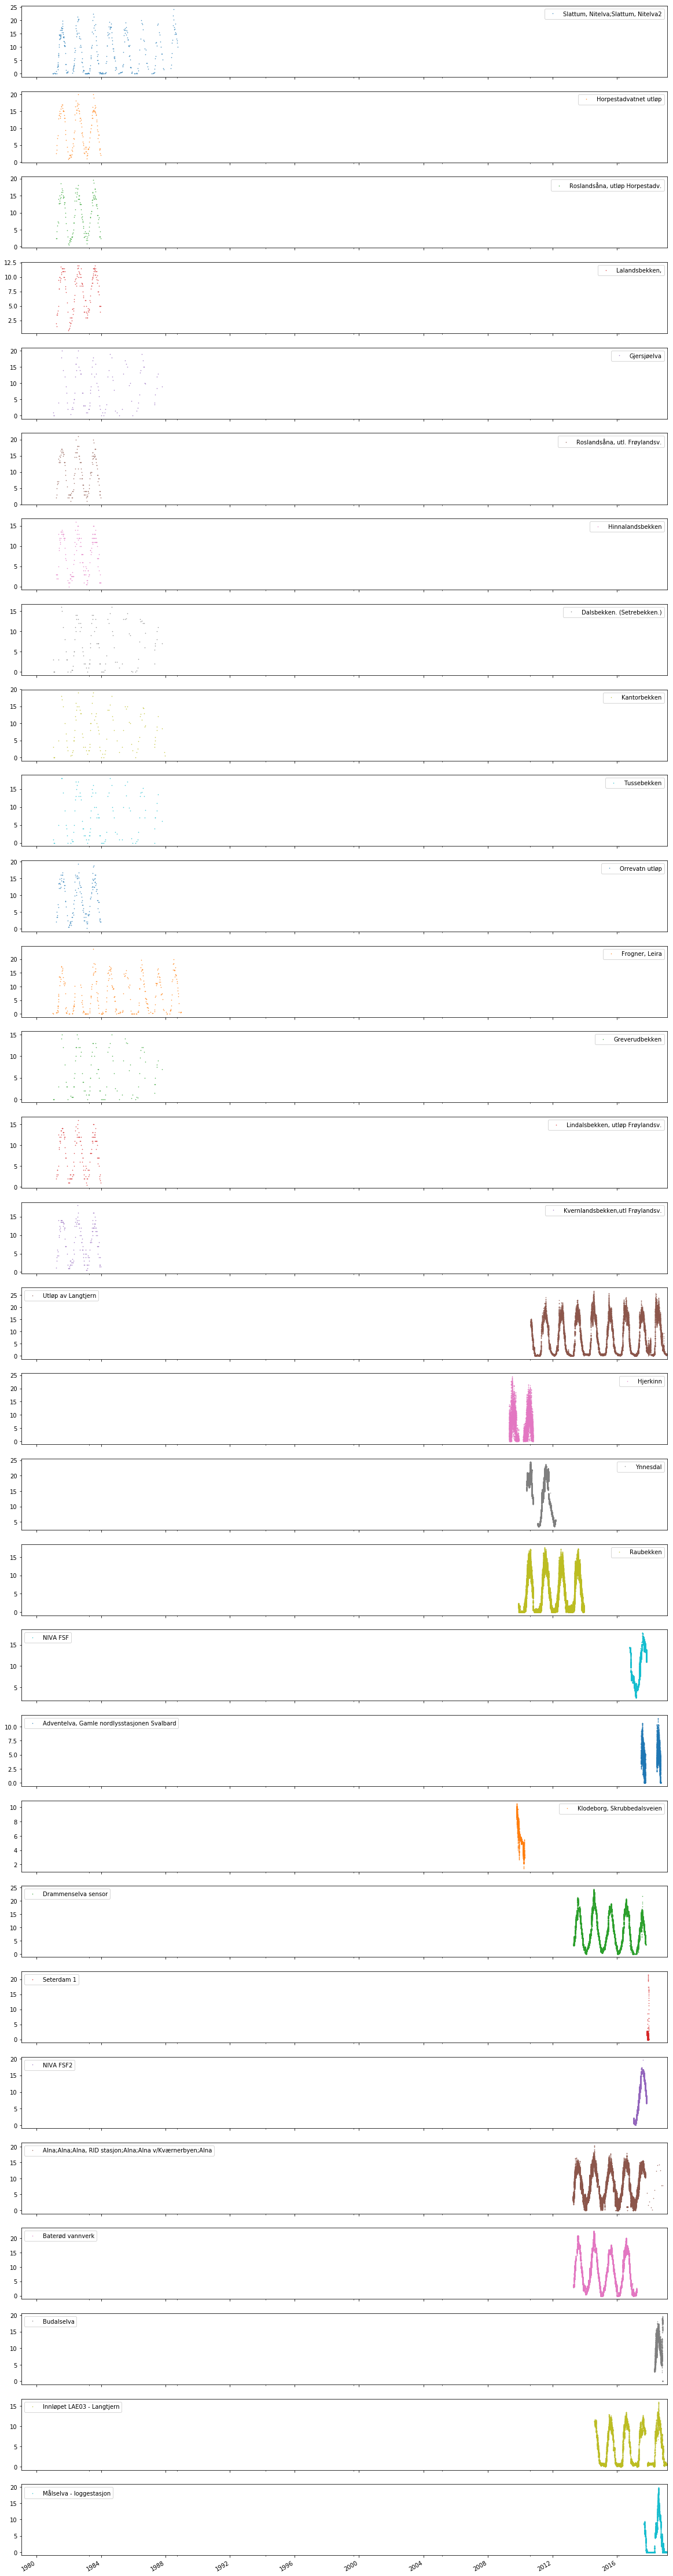

In [11]:
singleFrame.plot(subplots=True,figsize = (20,3*len(singleFrame.columns)),marker='.',linestyle='None',markersize=1)

There are not enough data to be do a long term analysis of the water temperature. It would be better to correlate to air temperature at the stations with enough data. That would be Langtjern, both inlet and outlet.
## Getting met data for air temperature.
The one kilometer gridded dataset from metno is used to extract the temperature data.



In [12]:
#Getting links to nectdf files containing mean and max temperature on a 1km grid
getList=False
baseURL='https://thredds.met.no/thredds/catalog/ngcd/version_18.09/catalog.html'
maxTemp='TX'
meanTemp='TG'
precip='RR'
model='type1'

only_a_tags = SoupStrainer("a", href=True)

def getSoup(url,re_str):
    request=requests.get(url)
    soup=BeautifulSoup(request.content,'lxml',parse_only=only_a_tags)
    link_soup=soup.find_all('a',text=re.compile(re_str))
    links=[]
    for i in link_soup:
        links.append(urljoin(url,i['href']))
    return links

def getFileList(var):
    allLinks=[]
    for var_link in getSoup(baseURL,var):
        for model_link in getSoup(var_link,model):
            for year_link in getSoup(model_link,'^[0-9]{4}/$'):
                print('Processing {}'.format(year_link))
                for month_link in getSoup(year_link,'^[0-9]{2}/$'):
                    for day_link in getSoup(month_link,'\\.nc$'):
                        for opendap_link in getSoup(day_link,'^/thredds/dodsC/'):
                            allLinks.append(re.sub(r'\.html$', '', opendap_link))
    return allLinks
    

if getList:
    maxTempLinks=getFileList(maxTemp)
    meanTempLinks=getFileList(meanTemp)
    precipLinks=getFileList(precip)
    with open('mean_temp_nc_files_{}.txt'.format(model), 'w') as f:
        for item in meanTempLinks:
            f.write("%s\n" % item)
    with open('max_temp_nc_files_{}.txt'.format(model), 'w') as f:
        for item in maxTempLinks:
            f.write("%s\n" % item)
    with open('precip_files_{}.txt'.format(model), 'w') as f:
        for item in precipLinks:
            f.write("%s\n" % item)

## Interpolating data to the coordinates of interest

In [12]:
instance = 'fimex'
username = 'jose-luis'
keyDir = 'fimex'
region = 'europe-west3-a'
machineType = 'n1-standard-16'

fimexGenerator = fimex.fimex(instance,username,region,keyDir,machineType)
fimexGenerator.instantiate()
print("The ip of the google cloud instance is {}".format(fimexGenerator.ip))

#Testing connection to instance

if fimexGenerator.instanceExists:
    p = Popen("ssh -i {0}/{1} {1}@{2} -o UserKnownHostsFile=/dev/null -o StrictHostKeyChecking=no".format(
            fimexGenerator.keyDir,
            fimexGenerator.username,
            fimexGenerator.ip
            ),
            shell=True,stdout=PIPE,stdin=PIPE)
    print(p.communicate())
    

The ip of the google cloud instance is 35.242.238.70
(b"Welcome to Ubuntu 16.04.5 LTS (GNU/Linux 4.15.0-1027-gcp x86_64)\n\n * Documentation:  https://help.ubuntu.com\n * Management:     https://landscape.canonical.com\n * Support:        https://ubuntu.com/advantage\n\n  Get cloud support with Ubuntu Advantage Cloud Guest:\n    http://www.ubuntu.com/business/services/cloud\n\n4 packages can be updated.\n0 updates are security updates.\n\nNew release '18.04.2 LTS' available.\nRun 'do-release-upgrade' to upgrade to it.\n\n\n", None)


In [13]:
getData = False
if getData:
    #Setting up configuration file for the interpolation
    cfg = 'interpolate.cfg'
    file = open('interpolate.cfg','w') 
    file.write('[interpolate]\n') 
    file.write('latitudeValues = {}\n'.format(','.join(df.LATITUDE.astype(str)))) 
    file.write('longitudeValues = {}\n'.format(','.join(df.LONGITUDE.astype(str)))) 
    file.close()
    #Actually downloading the data
    name='atle'
    fimexGenerator.setCommand('''fab getDataForCoordinates:{},{},{},{},{} '''.format('mean_temp_nc_files_{}.txt'.format(model),
                                                                   cfg,
                                                                   './temp_{}_nc'.format(name),
                                                                   'temp_{}.nc'.format(name),
                                                                     'dummy'
                                                                                )
                         )
    # fimexGenerator.callPopen(verbose=True,overwrite=True)
    # callPopen('''fab getDataForCoordinates:{},{},{},{},{} '''.format('max_temp_nc_files_{}.txt'.format(model),
    #                                                                cfg,
    #                                                                './max_temp_{}_nc'.format(name),
    #                                                                'max_temp_{}.nc'.format(name),
    #                                                                 'dummy' 
    #                                                                ),verbose=True,overwrite=True
    #                                                            ) 
    fimexGenerator.setCommand('''fab getDataForCoordinates:{},{},{},{},{} '''.format('precip_files_{}.txt'.format(model),
                                                                   cfg,
                                                                   './precip_{}_nc'.format(name),
                                                                   'precip_{}.nc'.format(name),
                                                                    'dummy' 
                                                                   )
                                                               ) 
    # fimexGenerator.callPopen(verbose=True,overwrite=True)

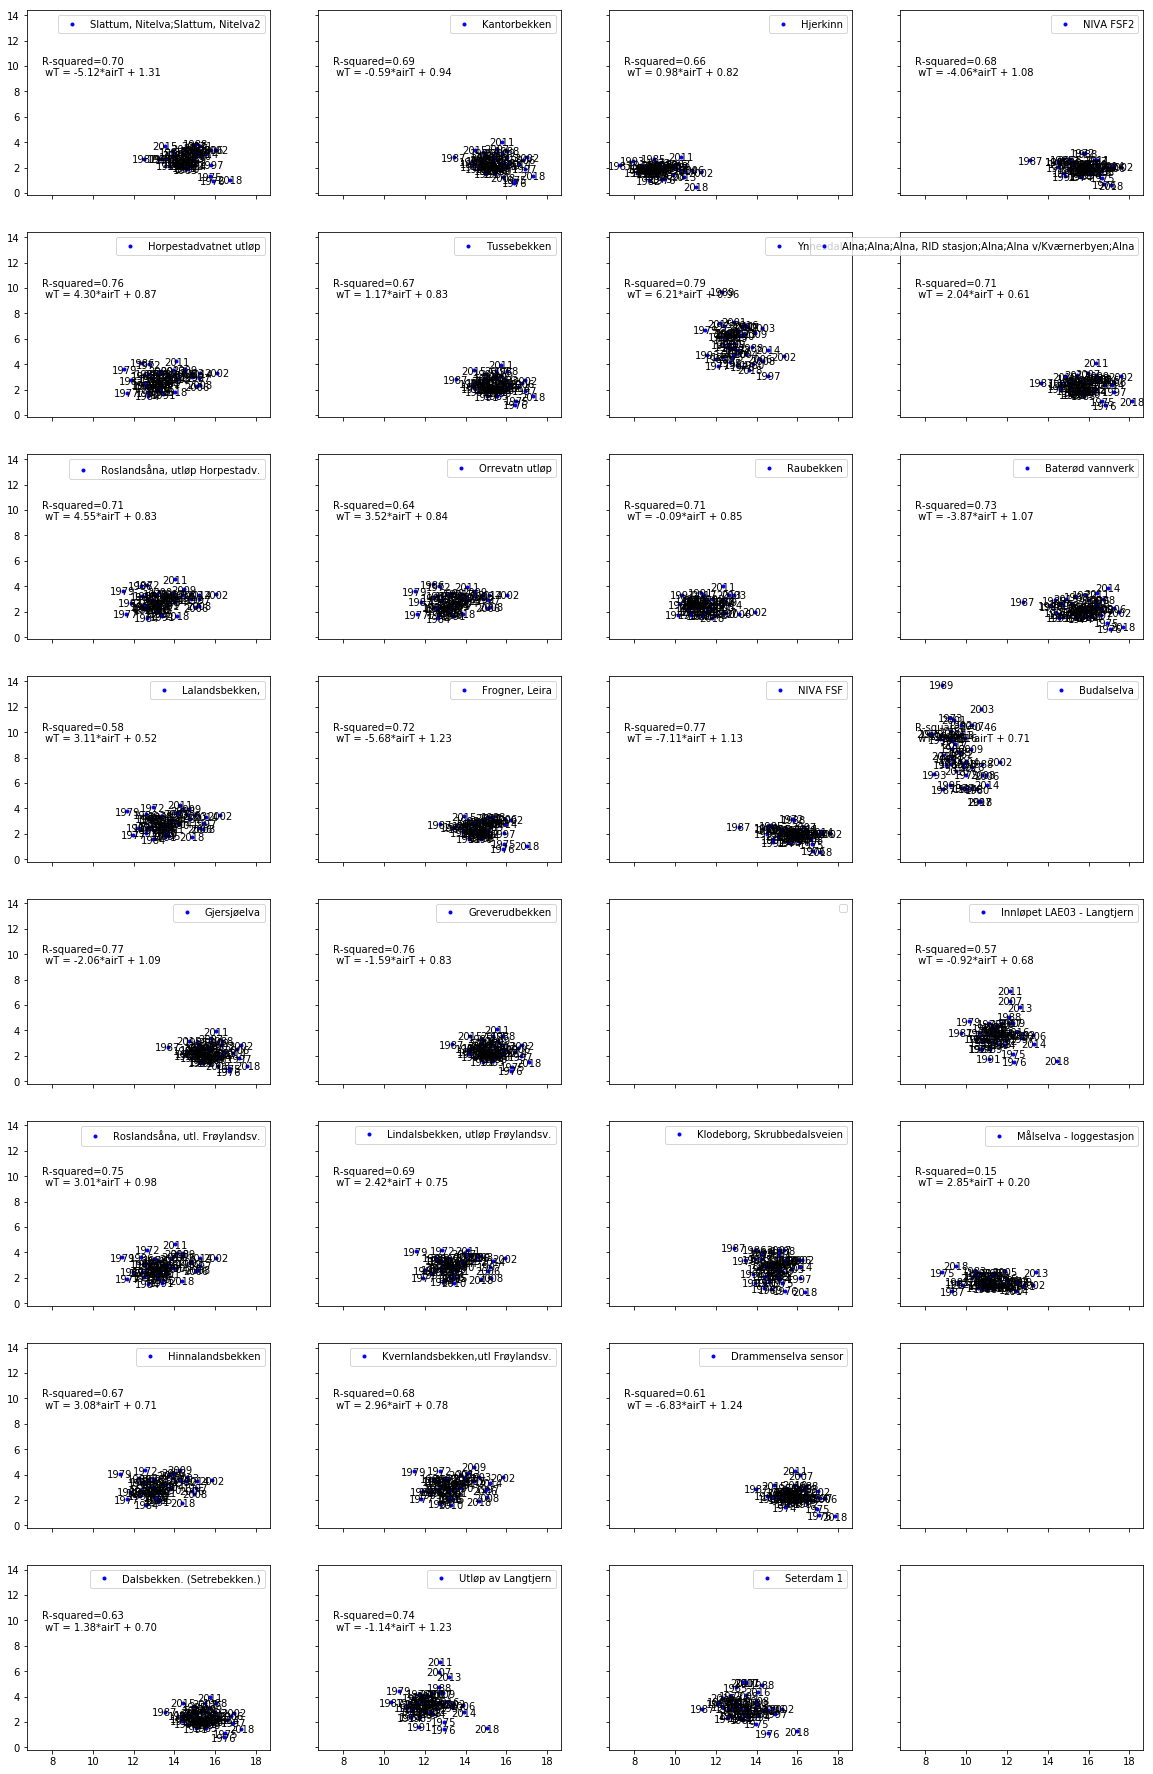

In [14]:
nc_file = temperatureFile = '~/Downloads/temp_atle.nc'
# nc_file = temperatureFile = './DownloadedData/temperature_all_coordinates.nc'
nc_data = xr.open_dataset(nc_file)
temperature = nc_data.TG - 272.15
temp_time = nc_data.time

nc_file = precip = '~/Downloads/precip_atle.nc'
# nc_file = precip = './precip.nc'
nc_data = xr.open_dataset(nc_file)
precipitation = nc_data.RR
precip_time = nc_data.time

summer_start = pd.to_datetime('2018-05-01').timetuple().tm_yday
summer_end = pd.to_datetime('2018-08-30').timetuple().tm_yday

numData = temperature.shape[2]
numCols = 4
numRows = math.ceil(numData/numCols)

df_r2 = pd.DataFrame()

f, ax = plt.subplots(numRows, numCols, sharex=True, sharey=True, figsize=(20,numRows*4))
def getYearly(date,var,vals,idx):
    df = pd.DataFrame({'date':date,var:vals.isel(x=idx,y=0)})
    df.set_index('date', inplace = True)
    ordinal = np.array(df.index.dayofyear)
    summer_idx = [summer_start <= x <= summer_end for x in ordinal]
    df = df.loc[summer_idx,:]
    return df.groupby(df.index.year).mean()

def getDf(date,var,vals,idx):
    df = pd.DataFrame({'date':date,var:vals.isel(x=idx,y=0)})
    df.set_index('date', inplace = True)
    ordinal = np.array(df.index.dayofyear)
    summer_idx = [summer_start <= x <= summer_end for x in ordinal]
    df = df.loc[summer_idx,:]
    return df

for cnt in range(numData):
    df_temp = getYearly(temp_time,'TG',temperature,cnt)
    df_precip = getYearly(precip_time,'RR',precipitation,cnt)
    ii = cnt%numRows
    jj = math.floor(cnt/numRows)
    isVal = np.logical_not(np.all(np.isnan(df_precip.RR.values)))
    name = df.STATION_NAME.values[cnt]
    if isVal:
        ax[ii,jj].plot(df_temp.TG,df_precip.RR,'bo',markersize=3)
    ax[ii,jj].legend([name])
    if isVal:
        for x,y,z in zip(df_temp.TG.values,df_precip.RR.values,df_temp.index):
            ax[ii,jj].annotate(str(z),  xy=(x,y), verticalalignment='center_baseline',horizontalalignment='center')
    #Getting rsquared 
    dummy = pd.DataFrame({'name':name,'rolling_mean':[np.nan],'day_values':[np.nan]})
    dummy.set_index('name', inplace = True)
    df_r2 = df_r2.append(dummy)
    if isVal:
        df_temp = getDf(temp_time,'TG',temperature,cnt)
        df_temp = df_temp.rolling(7).mean()
        df_precip = getDf(precip_time,'RR',precipitation,cnt)
        df_precip = df_precip.rolling(7).sum()
        df_water = singleFrame[name].dropna()
        df_water.name = 'waterTemp'
        predictor = pd.concat([df_temp,df_precip,df_water],axis=1).resample('d').mean()
        predictor.dropna(inplace=True)
        if predictor.shape[1] == 3 and predictor.shape[0] > 10:
            y, X = dmatrices('waterTemp ~ 1 + TG + RR', data=predictor)
            model = sm.OLS(y, X).fit()
            ax[ii,jj].annotate("R-squared={:.2f}\n wT = {:.2f}*airT + {:.2f}".format(model.rsquared,model.params[0],model.params[1]),  
                           xy=(7.5,10), 
                           verticalalignment='center_baseline',
                           horizontalalignment='left'
                          )
            df_r2.loc[name,'rolling_mean'] = model.rsquared
            
  

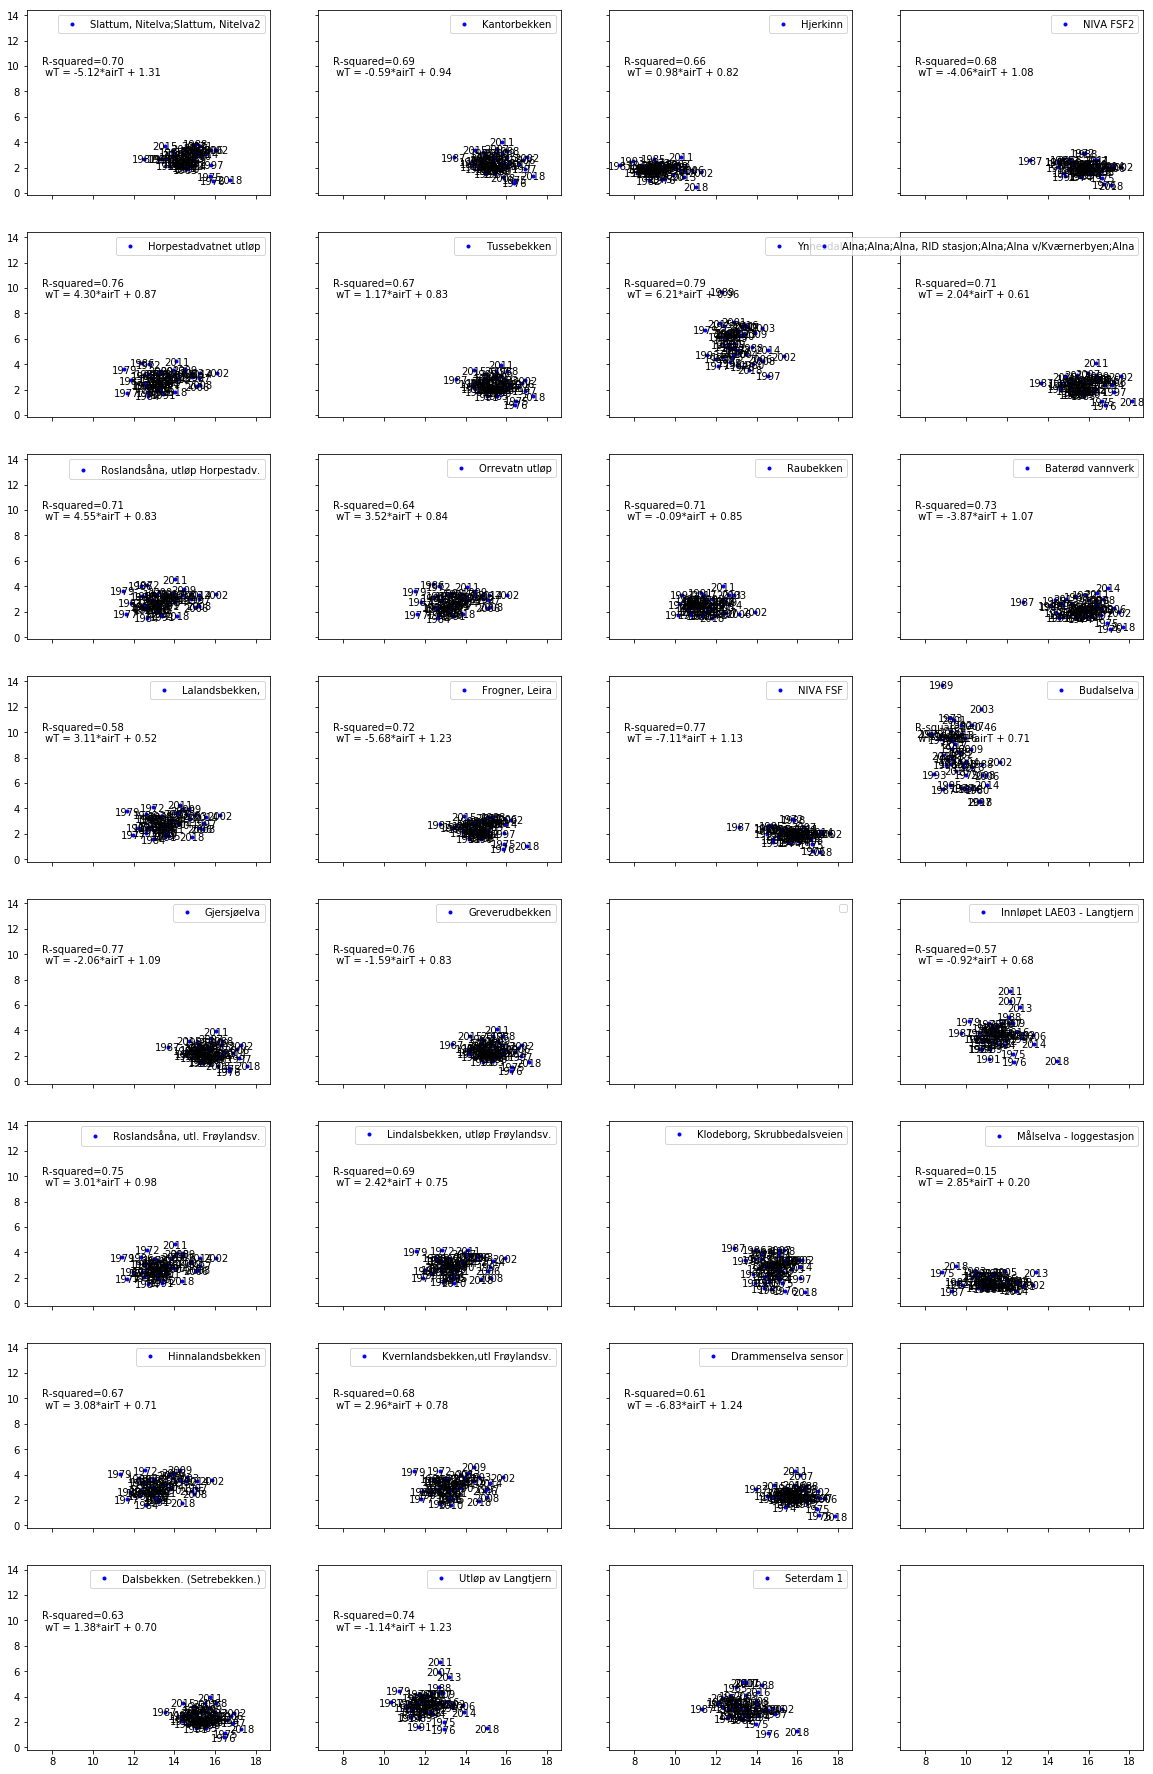

In [15]:
nc_file = temperatureFile = '~/Downloads/temp_atle.nc'
# nc_file = temperatureFile = './temperature.nc'
nc_data = xr.open_dataset(nc_file)
temperature = nc_data.TG - 272.15
temp_time = nc_data.time

nc_file = precip = '~/Downloads/precip_atle.nc'
# nc_file = precip = './precip.nc'
nc_data = xr.open_dataset(nc_file)
precipitation = nc_data.RR
precip_time = nc_data.time

summer_start = pd.to_datetime('2018-05-01').timetuple().tm_yday
summer_end = pd.to_datetime('2018-08-30').timetuple().tm_yday

numData = temperature.shape[2]
numCols = 4
numRows = math.ceil(numData/numCols)

df_r2 = pd.DataFrame()

f, ax = plt.subplots(numRows, numCols, sharex=True, sharey=True, figsize=(20,numRows*4))
def getYearly(date,var,vals,idx):
    df = pd.DataFrame({'date':date,var:vals.isel(x=idx,y=0)})
    df.set_index('date', inplace = True)
    ordinal = np.array(df.index.dayofyear)
    summer_idx = [summer_start <= x <= summer_end for x in ordinal]
    df = df.loc[summer_idx,:]
    return df.groupby(df.index.year).mean()

def getDf(date,var,vals,idx):
    df = pd.DataFrame({'date':date,var:vals.isel(x=idx,y=0)})
    df.set_index('date', inplace = True)
    ordinal = np.array(df.index.dayofyear)
    summer_idx = [summer_start <= x <= summer_end for x in ordinal]
    df = df.loc[summer_idx,:]
    return df

for cnt in range(numData):
    df_temp = getYearly(temp_time,'TG',temperature,cnt)
    df_precip = getYearly(precip_time,'RR',precipitation,cnt)
    ii = cnt%numRows
    jj = math.floor(cnt/numRows)
    isVal = np.logical_not(np.all(np.isnan(df_precip.RR.values)))
    name = df.STATION_NAME.values[cnt]
    if isVal:
        ax[ii,jj].plot(df_temp.TG,df_precip.RR,'bo',markersize=3)
    ax[ii,jj].legend([name])
    if isVal:
        for x,y,z in zip(df_temp.TG.values,df_precip.RR.values,df_temp.index):
            ax[ii,jj].annotate(str(z),  xy=(x,y), verticalalignment='center_baseline',horizontalalignment='center')
    #Getting rsquared 
    dummy = pd.DataFrame({'name':name,'rolling_mean':[np.nan],'day_values':[np.nan]})
    dummy.set_index('name', inplace = True)
    df_r2 = df_r2.append(dummy)
    if isVal:
        df_temp = getDf(temp_time,'TG',temperature,cnt)
        df_temp = df_temp.rolling(7).mean()
        df_precip = getDf(precip_time,'RR',precipitation,cnt)
        df_precip = df_precip.rolling(7).sum()
        df_water = singleFrame[name].dropna()
        df_water.name = 'waterTemp'
        predictor = pd.concat([df_temp,df_precip,df_water],axis=1).resample('d').mean()
        predictor.dropna(inplace=True)
        if predictor.shape[1] == 3 and predictor.shape[0] > 10:
            y, X = dmatrices('waterTemp ~ 1 + TG + RR', data=predictor)
            model = sm.OLS(y, X).fit()
            ax[ii,jj].annotate("R-squared={:.2f}\n wT = {:.2f}*airT + {:.2f}".format(model.rsquared,model.params[0],model.params[1]),  
                           xy=(7.5,10), 
                           verticalalignment='center_baseline',
                           horizontalalignment='left'
                          )
            df_r2.loc[name,'rolling_mean'] = model.rsquared
            
  

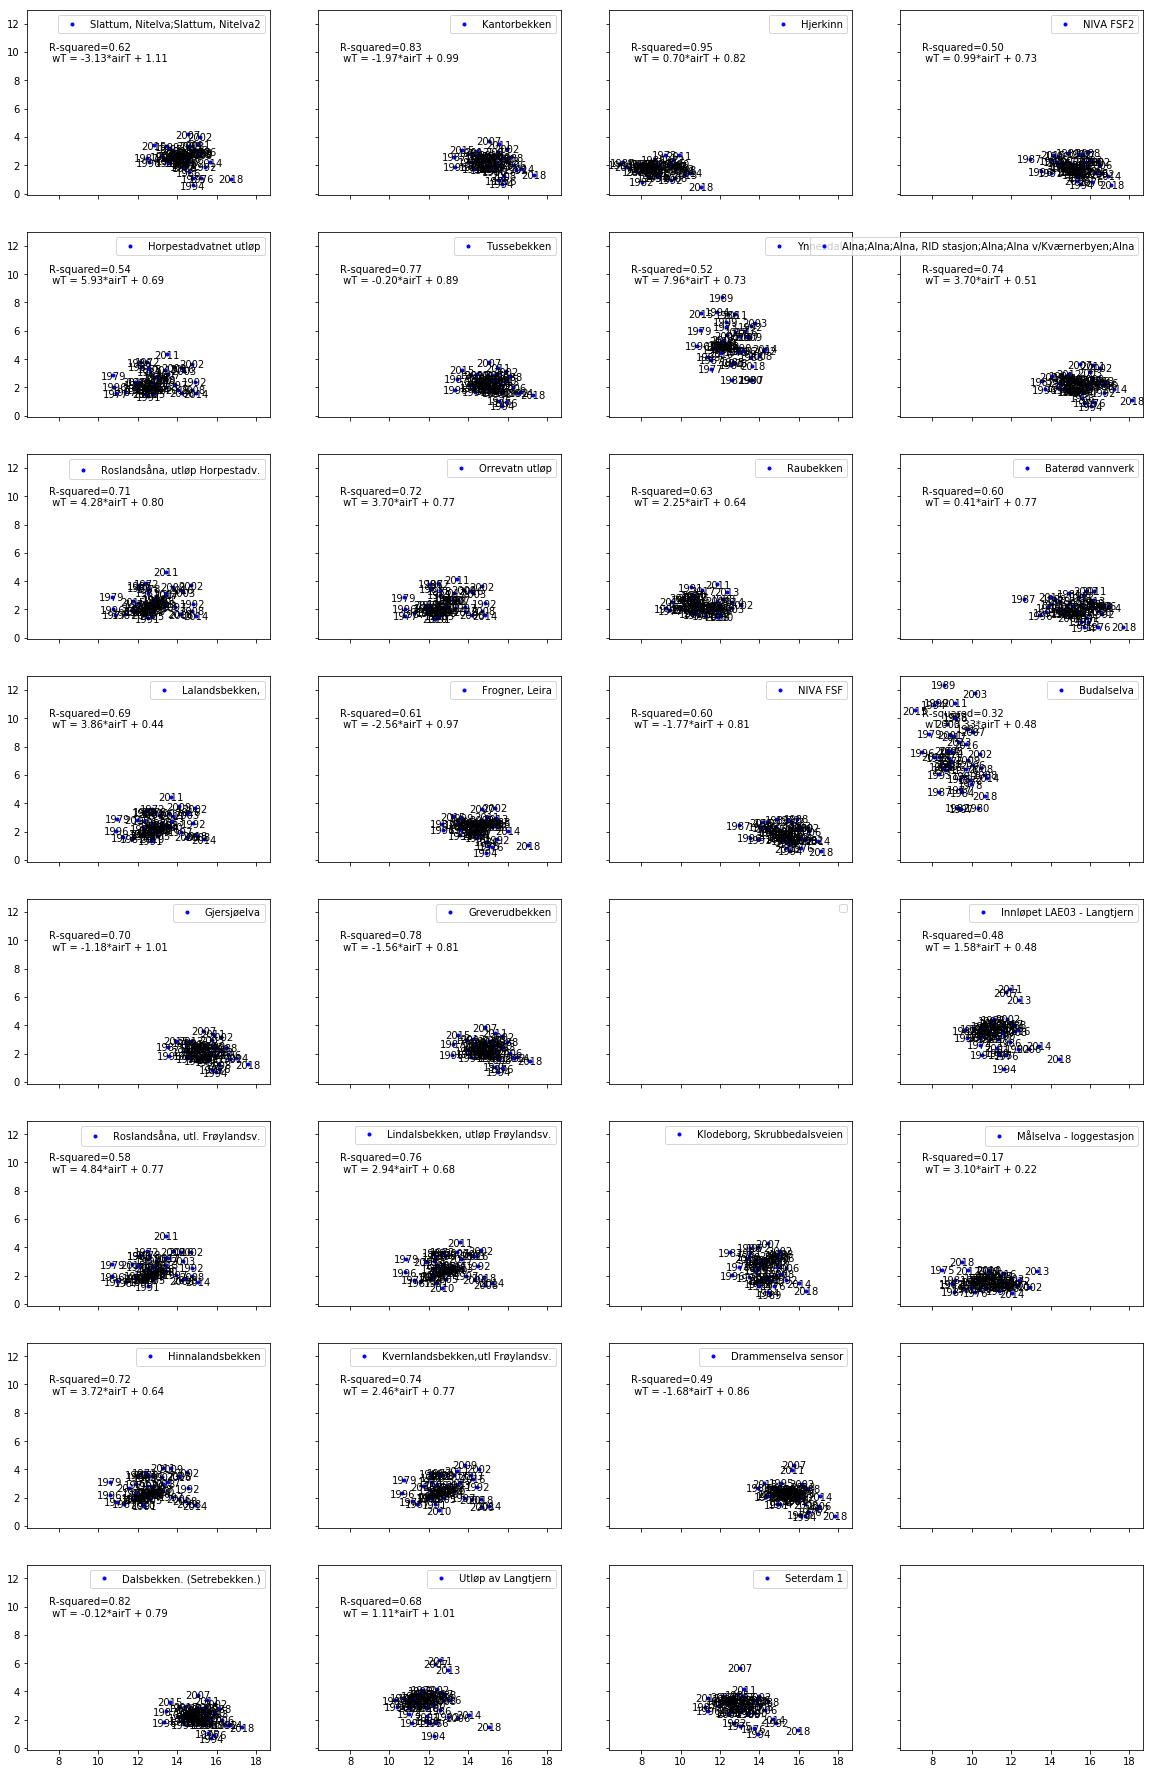

In [16]:
nc_file = temperatureFile = '~/Downloads/temp_atle.nc'
# nc_file = temperatureFile = './temperature.nc'
nc_data = xr.open_dataset(nc_file)
temperature = nc_data.TG - 272.15
temp_time = nc_data.time

nc_file = precip = '~/Downloads/precip_atle.nc'
# nc_file = precip = './precip.nc'
nc_data = xr.open_dataset(nc_file)
precipitation = nc_data.RR
precip_time = nc_data.time

summer_start = pd.to_datetime('2018-05-01').timetuple().tm_yday
summer_end = pd.to_datetime('2018-07-31').timetuple().tm_yday

numData = temperature.shape[2]
numCols = 4
numRows = math.ceil(numData/numCols)

f, ax = plt.subplots(numRows, numCols, sharex=True, sharey=True, figsize=(20,numRows*4))


def getYearly(date,var,vals,idx):
    df = pd.DataFrame({'date':date,var:vals.isel(x=idx,y=0)})
    df.set_index('date', inplace = True)
    ordinal = np.array(df.index.dayofyear)
    summer_idx = [summer_start <= x <= summer_end for x in ordinal]
    df = df.loc[summer_idx,:]
    return df.groupby(df.index.year).mean()

def getDf(date,var,vals,idx):
    df = pd.DataFrame({'date':date,var:vals.isel(x=idx,y=0)})
    df.set_index('date', inplace = True)
    ordinal = np.array(df.index.dayofyear)
    summer_idx = [summer_start <= x <= summer_end for x in ordinal]
    df = df.loc[summer_idx,:]
    return df

for cnt in range(numData):
    df_temp = getYearly(temp_time,'TG',temperature,cnt)
    df_precip = getYearly(precip_time,'RR',precipitation,cnt)
    ii = cnt%numRows
    jj = math.floor(cnt/numRows)
    isVal = np.logical_not(np.all(np.isnan(df_precip.RR.values)))
    name = df.STATION_NAME.values[cnt]
    if isVal:
        ax[ii,jj].plot(df_temp.TG,df_precip.RR,'bo',markersize=3)
    ax[ii,jj].legend([name])
    if isVal:
        for x,y,z in zip(df_temp.TG.values,df_precip.RR.values,df_temp.index):
            ax[ii,jj].annotate(str(z),  xy=(x,y), verticalalignment='center_baseline',horizontalalignment='center')
    #Getting rsquared 
    if isVal:
        df_temp = getDf(temp_time,'TG',temperature,cnt)
        df_precip = getDf(precip_time,'RR',precipitation,cnt)
        df_water =singleFrame[name].dropna()
        df_water.name = 'waterTemp'
        predictor = pd.concat([df_temp,df_precip,df_water],axis=1).resample('d').mean()
        predictor.dropna(inplace=True)
        if predictor.shape[1] == 3 and predictor.shape[0] > 10:
            y, X = dmatrices('waterTemp ~ 1 + TG + RR', data=predictor)
            model = sm.OLS(y, X).fit()
            ax[ii,jj].annotate("R-squared={:.2f}\n wT = {:.2f}*airT + {:.2f}".format(model.rsquared,model.params[0],model.params[1]),  
                           xy=(7.5,10), 
                           verticalalignment='center_baseline',
                           horizontalalignment='left'
                          )
            df_r2.loc[name,'day_values'] = model.rsquared
            

In [17]:
display(df_r2)

,rolling_mean,day_values
name,,
"Slattum, Nitelva;Slattum, Nitelva2",0.696044,0.624860
Horpestadvatnet utløp,0.756563,0.537083
"Roslandsåna, utløp Horpestadv.",0.708048,0.707550
"Lalandsbekken,",0.584676,0.687631
Gjersjøelva,0.773156,0.699720
"Roslandsåna, utl. Frøylandsv.",0.751962,0.578397
Hinnalandsbekken,0.670121,0.718750
Dalsbekken. (Setrebekken.),0.631411,0.817249
Kantorbekken,0.693747,0.829346


In [1]:
df_r2 = df_r2.rename(index={'Slattum, Nitelva;Slattum, Nitelva2': 'Slattum, Nitelva', 'Alna;Alna;Alna, RID stasjon;Alna;Alna v/Kværnerbyen;Alna': 'Alna v/Kværnerbyen'})


ax = df_r2.dropna().plot(linestyle='None',marker='o',markersize=10,figsize=(20,10),x_compat=False)
plt.xticks(np.arange(28), df_r2.dropna().index.values,rotation='vertical')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height*0.6 , box.width, box.height*.5])
ax.set_xlim(-1,28)
ax.set_ylabel('R²')
ax.set_xlabel('Stations')

plt.savefig('correlation.png')


# ax = referenceFrame.resample('m').mean().plot(figsize=(12,20),linestyle='None', marker = '+' ) 
# ax.legend(loc = 'lower center', fancybox=True,ncol = 2,bbox_to_anchor=(0.5, -1.2))
# box = ax.get_position()
# ax.set_position([box.x0, box.y0 + box.height*0.6 , box.width, box.height*.5])

NameError: name 'df_r2' is not defined

In [27]:
display(len(df_r2.dropna()))

27